## Multi agents using LangGraph

## Challenges with single agents

Single agent systems are not efficient for diverse tasks or for applications which may require multiple tools. Imagine input context size if have to use 100s and 1000s of tools. Each tool has its own description and input/output schema. In such cases, it is difficult to use a single model that can handle all the tools.

Some of the common challenges are: 
- Infelxibility: our agentic application is limited to one LLM
- Contextual overload - too much information in the context
- Lack of parallel processing 
- Single point of failure 



## Multi agents

In multi agent systems, each agent can have its own prompt, LLM and tools. 

Benefits of multi agent systems:
- Agent can be more efficient as it has its on focused tasks
- Logical grouping of tools can give better results
- Easy to manage prompts for individual agents
- Each agent can be tested and evaluated separately



In this example we are going to use supervisor agentic pattern. In this pattern multiple agents are connected via supervisor agent but ecah agent has its own scratchpad. 

<!-- ![image-2.png](assets/multi-agent-overview.png) -->

<img src="multi-agent-overview.png" alt="image" style="width:800px;height:auto;"/>

## Setup

Let's start with installing required packages

In [ ]:
%pip install -U langchain-community langgraph langchain-chroma langchain_aws pandas

You can add LangSmith api key to set up observability

:::info

This is an optional step that will help you understand how your agents are working.

:::

In [1]:
import getpass
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass()
os.environ["LANGCHAIN_PROJECT"] = "lc-agent-sample"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"

## Flight agent

To create flight agent we will create few tools to search flights, retrieve booking information, change flight and cancel booking.

### Tools

In [1]:
from langchain_core.tools import tool
import random
from datetime import datetime, timedelta
from langgraph.prebuilt import ToolNode
import sqlite3


@tool
def search_flights(departure_city: str, arrival_city: str, date: str = None) -> str:
    """
    Use this tool to search for flights between two cities

    Args:
        departure_city (str): The city of departure
        arrival_city (str): The city of arrival
        date (str, optional): The date of the flight in YYYY-MM-DD format. If not provided, defaults to 7 days from now.

    Returns:
        str: A formatted string containing flight information including airline, departure time, arrival time, duration, and price for multiple flights.
    """
    departure_city = departure_city.capitalize()
    arrival_city = arrival_city.capitalize()

    if date is None:
        date = (datetime.now() + timedelta(days=7)).strftime("%Y-%m-%d")

    # Generate mock flight data
    num_flights = random.randint(2, 5)
    airlines = ["AirEurope", "SkyWings", "TransContinental", "EuroJet", "GlobalAir"]
    flights = []

    for _ in range(num_flights):
        airline = random.choice(airlines)
        duration = timedelta(minutes=2)
        price = random.randint(100, 400)
        departure_time = datetime.strptime(date, "%Y-%m-%d") + timedelta(
            hours=random.randint(0, 23), minutes=random.randint(0, 59)
        )
        arrival_time = departure_time + duration

        flights.append(
            {
                "airline": airline,
                "departure": departure_time.strftime("%H:%M"),
                "arrival": arrival_time.strftime("%H:%M"),
                "duration": str(duration),
                "price": price,
            }
        )

    # Format the results
    import json

    flight_data = {
        "departure_city": departure_city,
        "arrival_city": arrival_city,
        "date": date,
        "flights": []
    }
    for i, flight in enumerate(flights, 1):
        flight_info = {
            "flight_number": i,
            "airline": flight['airline'],
            "departure": flight['departure'],
            "arrival": flight['arrival'],
            "duration": str(flight['duration']),
            "price": flight['price']
        }
        flight_data["flights"].append(flight_info)

    return json.dumps(flight_data) + " FINISHED"


In [2]:
@tool
def retrieve_flight_booking(booking_id: str) -> str:
    """
    Retrieve a flight booking by ID

    Args:
        booking_id (str): The unique identifier of the booking to retrieve

    Returns:
        str: A string containing the booking information if found, or a message indicating no booking was found
    """
    conn = sqlite3.connect("data/travel_bookings.db")
    cursor = conn.cursor()

    # Execute the query to retrieve the booking
    cursor.execute("SELECT * FROM flight_bookings WHERE booking_id = ?", (booking_id,))
    booking = cursor.fetchone()

    # Close the connection
    conn.close()

    if booking:
        return f"Booking found: {booking}"
    else:
        return f"No booking found with ID: {booking_id} FINISHED"

In [3]:
@tool
def change_flight_booking(booking_id: str, new_date: str) -> str:
    """
    Change the date of a flight booking

    Args:
        booking_id (str): The unique identifier of the booking to be changed
        new_date (str): The new date for the booking

    Returns:
        str: A message indicating the result of the booking change operation
    """
    conn = sqlite3.connect("data/travel_bookings.db")
    cursor = conn.cursor()

    # Execute the query to update the booking date
    cursor.execute(
        "UPDATE flight_bookings SET departure_date = ? WHERE booking_id = ?",
        (new_date, booking_id),
    )
    conn.commit()

    # Check if the booking was updated
    if cursor.rowcount > 0:
        result = f"Booking updated with ID: {booking_id}, new date: {new_date} FINISHED"
    else:
        result = f"No booking found with ID: {booking_id} FINISHED"

    # Close the connection
    conn.close()

    return result 

In [4]:
@tool
def cancel_flight_booking(booking_id: str) -> str:
    """
    Cancel a flight booking. If the task complete, reply with "FINISHED"

    Args:
        booking_id (str): The unique identifier of the booking to be cancelled

    Returns:
        str: A message indicating the result of the booking cancellation operation

    """
    conn = sqlite3.connect("data/travel_bookings.db")
    cursor  = conn.cursor()

    cursor.execute("DELETE FROM flight_bookings WHERE booking_id = ?", (booking_id,))
    conn.commit()

    # Check if the booking was deleted
    if cursor.rowcount > 0:
        result = f"Booking canceled with ID: {booking_id} FINISHED"
    else:
        result = f"No booking found with ID: {booking_id} FINISHED"

    # Close the connection
    conn.close()

    return result

In [5]:
from langchain_aws import ChatBedrockConverse
from langchain_aws import ChatBedrock
import boto3

# ---- ⚠️ Update region for your AWS setup ⚠️ ----
bedrock_client = boto3.client("bedrock-runtime", region_name="us-east-1")

llm = ChatBedrockConverse(
    model="anthropic.claude-3-sonnet-20240229-v1:0",
    # model="anthropic.claude-3-5-sonnet-20240620-v1:0",
    temperature=0,
    max_tokens=None,
    client=bedrock_client,
    # other params...
)

### Flight Agent setup

We are going to use `create_react_agent` to create a flight agent. This is a prebuilt component from LangGraph build the agent with tools. We can also build it from scratch but we to keep it simple we will use the prebuilt one.

We can customize the prompt using `state_modifier`

In [6]:
import functools
import operator
from typing import Sequence, TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent

from typing import Annotated
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver

class State(TypedDict):
    messages: Annotated[list, add_messages]
    next: str

memory = MemorySaver()


flight_agent = create_react_agent(
    llm,
    tools=[
        search_flights,
        retrieve_flight_booking,
        change_flight_booking,
        cancel_flight_booking,
    ],
    state_modifier="""
    First gather all the information required to call a tool. 
    If you are not able to find the booking the do not try again and just reply with "FINISHED". 
    If tool has returned the results then reply with "FINISHED"
    If all tasks are complete, reply with "FINISHED"
    """,
    checkpointer=memory,
)

Let's put this to test. 

In [7]:
config = {"configurable": {"thread_id": "121"}}
flight_agent.invoke({"messages": [("user", "Can you give me booking details of booking number 10")]}, config)

{'messages': [HumanMessage(content='Can you give me booking details of booking number 10', additional_kwargs={}, response_metadata={}, id='1fd17e73-6452-48e2-a31e-c64d977ae3c3'),
  AIMessage(content=[{'type': 'tool_use', 'name': 'retrieve_flight_booking', 'input': {'booking_id': '10'}, 'id': 'tooluse_nBT4hrONQYabp6zGHSq7hA'}], additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': '236d66be-cf3a-4f2c-badd-19c0e5d945dd', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Fri, 04 Oct 2024 20:06:32 GMT', 'content-type': 'application/json', 'content-length': '292', 'connection': 'keep-alive', 'x-amzn-requestid': '236d66be-cf3a-4f2c-badd-19c0e5d945dd'}, 'RetryAttempts': 0}, 'stopReason': 'tool_use', 'metrics': {'latencyMs': 4282}}, id='run-812ff801-f32c-42aa-ac20-11c1cd4c5b00-0', tool_calls=[{'name': 'retrieve_flight_booking', 'args': {'booking_id': '10'}, 'id': 'tooluse_nBT4hrONQYabp6zGHSq7hA', 'type': 'tool_call'}], usage_metadata={'input_tokens': 804, 'output_tokens': 57

## Hotel Agent

Just like flight agent we need to create few tools, which can manage hotel bookings. We will use the same approach as we did with flight agents. We will create a class that will be responsible for booking hotels and also provide some methods to get information about available hotels in certain city or price range.


In [67]:
import json

@tool
def suggest_hotels(city: str, checkin_date: str) -> dict:
    """
    Use this tool to search for hotels in these cities

    Args:
        city (str): The name of the city to search for hotels
        checkin_date (str): The check-in date in YYYY-MM-DD format

    Returns:
        dict: A dictionary containing:
            - hotels (list): List of hotel names in the specified city
            - checkin_date (str): The provided check-in date
            - checkout_date (str): A randomly generated checkout date
            - price (int): A randomly generated price for the stay
    """
    hotels = {
        "New York": ["Hotel A", "Hotel B", "Hotel C"],
        "Paris": ["Hotel D", "Hotel E", "Hotel F"],
        "Tokyo": ["Hotel G", "Hotel H", "Hotel I"],
    }

    # Generate random checkout date and price
    checkin = datetime.strptime(checkin_date, "%Y-%m-%d")
    checkout = checkin + timedelta(days=random.randint(1, 10))
    price = random.randint(100, 500)

    hotel_list = hotels.get(city, ["No hotels found"])
    hotel_data = {
        "hotels": hotel_list,
        "checkin_date": checkin_date,
        "checkout_date": checkout.strftime("%Y-%m-%d"),
        "price": price,
    }

    return json.dumps(hotel_data) + " FINISHED"

In [41]:
@tool
def retrieve_hotel_booking(booking_id: str) -> str:
    """
    Retrieve a hotel booking by ID

    Args:
        booking_id (str): The unique identifier of the hotel booking to retrieve

    Returns:
        str: A string containing the hotel booking information if found, or a message indicating no booking was found
    """
    conn = sqlite3.connect("data/travel_bookings.db")
    cursor = conn.cursor()
    cursor.execute(f"SELECT * FROM hotel_bookings WHERE booking_id='{booking_id}'")
    booking = cursor.fetchone()

    # Close the connection
    conn.close()

    if booking:
        return f"Booking found: {booking} FINISHED"
    else:
        return f"No booking found with ID: {booking_id} FINISHED"

In [42]:
from datetime import datetime

@tool
def change_hotel_booking(
    booking_id: int, new_checkin_date: str = None, new_checkout_date: str = None
) -> str:
    """
    Change the dates of a hotel booking in the database

    Args:
    booking_id (int): The unique identifier of the booking to be changed
    new_checkin_date (str, optional): The new check-in date in YYYY-MM-DD format
    new_checkout_date (str, optional): The new check-out date in YYYY-MM-DD format

    Returns:
    str: A message indicating the result of the booking change operation
    """

    conn = sqlite3.connect("data/travel_bookings.db")  # Replace with your actual database file
    cursor = conn.cursor()

    try:
        # First, fetch the current booking details
        cursor.execute(
            """
            SELECT * FROM hotel_bookings WHERE booking_id = ?
        """,
            (booking_id,),
        )

        booking = cursor.fetchone()

        if booking is None:
            return f"No hotel booking found with ID: {booking_id}"

        # Unpack the booking details
        (
            _,
            user_id,
            user_name,
            city,
            hotel_name,
            check_in_date,
            check_out_date,
            nights,
            price_per_night,
            total_price,
            num_guests,
            room_type,
        ) = booking

        # Update check-in and check-out dates if provided
        if new_checkin_date:
            check_in_date = new_checkin_date
        if new_checkout_date:
            check_out_date = new_checkout_date

        # Recalculate nights and total price
        checkin = datetime.strptime(check_in_date, "%Y-%m-%d")
        checkout = datetime.strptime(check_out_date, "%Y-%m-%d")
        nights = (checkout - checkin).days
        total_price = nights * price_per_night

        # Update the booking in the database
        cursor.execute(
            """
            UPDATE hotel_bookings
            SET check_in_date = ?, check_out_date = ?, nights = ?, total_price = ?
            WHERE booking_id = ?
        """,
            (check_in_date, check_out_date, nights, total_price, booking_id),
        )

        conn.commit()

        return f"Hotel booking updated: Booking ID {booking_id}, New check-in: {check_in_date}, New check-out: {check_out_date}, Nights: {nights}, Total Price: {total_price} FINISHED"

    except sqlite3.Error as e:
        conn.rollback()
        return f"An error occurred: {str(e)} FINISHED"

    finally:
        conn.close()

In [43]:
@tool
def cancel_hotel_booking(booking_id: str) -> str:
    """
    Cancel a hotel booking. If the task completes, reply with "FINISHED"

    Args:
        booking_id (str): The unique identifier of the booking to be cancelled

    Returns:
        str: A message indicating the result of the booking cancellation operation
    """
    conn = sqlite3.connect("data/travel_bookings.db")
    cursor  = conn.cursor()

    cursor.execute("DELETE FROM hotel_bookings WHERE booking_id = ?", (booking_id,))
    conn.commit()

    # Check if the booking was deleted
    if cursor.rowcount > 0:
        result = f"Booking canceled with ID: {booking_id} FINISHED"
    else:
        result = f"No booking found with ID: {booking_id} FINISHED"

    # Close the connection
    conn.close()

    return result

## Hotel agent from scratch

So far we have seen how to create agent using `create_react_agent` class of LangGraph, which has simplified things for us. But we need more control over how this agent is working. We need our agent to ask additional questions based on the previous response and also ask for confirmation before moving to next step. We will create a custom agent that can handle these things. We will create `AskHuman` node in the graph that can interrupt the agent execution and ask for additional information. 

In [12]:
from langchain_core import __version__ as core_version
from packaging import version

core_version = version.parse(core_version)
if (core_version.major, core_version.minor) < (0, 3):
    from pydantic.v1 import BaseModel
else:
    from pydantic import BaseModel
from typing import Literal

class AskHuman(BaseModel):
    """Ask missing information from the user"""

    question: str

In [80]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig


class hotel_agent:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            configuration = config.get("configurable", {})
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                # messages = state["messages"] + [("user", "Respond with a real output.")]
                messages = state["messages"]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful who manage hotel bookings"
            " If you dont have enough information use AskHuman tool to get additional information. "
            " City name is required to search hotels",
        ),
        ("placeholder", "{messages}"),
    ]
)
hotel_tools = [
    suggest_hotels,
    retrieve_hotel_booking,
    change_hotel_booking,
    cancel_hotel_booking,
]

runnable_with_tools = primary_assistant_prompt | llm.bind_tools(
    hotel_tools + [AskHuman]
)

In [45]:
# We define a fake node to ask the human
def ask_human(state):
    pass

In [46]:
from langgraph.prebuilt import ToolNode, tools_condition

tool_node = ToolNode(hotel_tools+[AskHuman])

We need to check which node is executed next. This function can check the state and decide which node to execute next of end the execution.

In [47]:
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    elif last_message.tool_calls[0]["name"] == "AskHuman":
        return "ask_human"
    # Otherwise if there is, we continue
    else:
        return "continue"

Let's add all the nodes in the graph and compile it

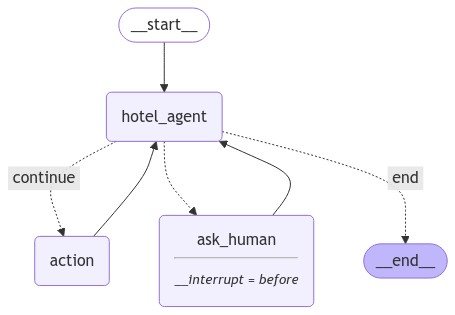

In [81]:
from langgraph.graph import END, StateGraph, MessagesState
from IPython.display import Image, display

# Define a new graph
workflow = StateGraph(MessagesState)

# Define the three nodes we will cycle between
workflow.add_node("hotel_agent", hotel_agent(runnable_with_tools))
workflow.add_node("action", tool_node)
workflow.add_node("ask_human", ask_human)

workflow.add_edge(START, "hotel_agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    "hotel_agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # We may ask the human
        "ask_human": "ask_human",
        # Otherwise we finish.
        "end": END,
    },
)


workflow.add_edge("action", "hotel_agent")

# After we get back the human response, we go back to the agent
workflow.add_edge("ask_human", "hotel_agent")

# Set up memory
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

app = workflow.compile(checkpointer=memory, interrupt_before=["ask_human"])

display(Image(app.get_graph().draw_mermaid_png()))

Now we cab test this agent that we have created from scratch.

In [49]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "128"}}
input_message = HumanMessage(content="I want to book a hotel for 8th October for 3 nights")
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

I want to book a hotel for 8th October for 3 nights
================================== Ai Message ==================================

[{'type': 'text', 'text': "Okay, let me help you book a hotel for your stay. I'll need to know the city you want to stay in. Please provide the city name and I'll search for available hotels."}, {'type': 'tool_use', 'name': 'AskHuman', 'input': {'question': 'What city would you like to book a hotel in?'}, 'id': 'tooluse_ORtYo-16T-KparqB7fpTRA'}]
Tool Calls:
  AskHuman (tooluse_ORtYo-16T-KparqB7fpTRA)
 Call ID: tooluse_ORtYo-16T-KparqB7fpTRA
  Args:
    question: What city would you like to book a hotel in?


We need to update the graph state with user response. 

In [50]:
user_input = input("User: ")

In [51]:
tool_call_id = app.get_state(config).values["messages"][-1].tool_calls[0]["id"]

# We now create the tool call with the id and the response we want
tool_message = [{"tool_call_id": tool_call_id, "type": "tool", "content": user_input}]

app.update_state(config, {"messages": tool_message}, as_node="ask_human")

app.get_state(config).next

('hotel_agent',)

Once we have updated the state, we just need to execute the graph with empty input.

In [22]:
for event in app.stream(None, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================

Paris
================================== Ai Message ==================================

[{'type': 'text', 'text': 'Got it, you need a hotel in Paris for 3 nights checking in on 2023-10-08. Let me search for available hotels:'}, {'type': 'tool_use', 'name': 'suggest_hotels', 'input': {'city': 'Paris', 'checkin_date': '2023-10-08'}, 'id': 'tooluse_-9rl4UjJT9uKRBnMehUefw'}]
Tool Calls:
  suggest_hotels (tooluse_-9rl4UjJT9uKRBnMehUefw)
 Call ID: tooluse_-9rl4UjJT9uKRBnMehUefw
  Args:
    city: Paris
    checkin_date: 2023-10-08
================================= Tool Message =================================
Name: suggest_hotels

{"hotels": ["Hotel D", "Hotel E", "Hotel F"], "checkin_date": "2023-10-08", "checkout_date": "2023-10-18", "price": 338}
================================== Ai Message ==================================

Here are some available hotels in Paris for your 3 night stay checking in on Octob

## Supervisor agent

Now its time to create supervisor agent that will be in charge of deciding which child agent to call based on the user input and based on the conversation history. 

We will create this agent with LangChain runnable chain created using supervisor prompt. We need to get the `next_step` from the chain and we use `with_structured_output` to return next step.

In [23]:
from langchain_core.runnables import Runnable, RunnableConfig
from langgraph.graph.message import add_messages
from typing import Annotated, Sequence, List
from langchain_core.messages import HumanMessage

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core import __version__ as core_version
from packaging import version

core_version = version.parse(core_version)
if (core_version.major, core_version.minor) < (0, 3):
    from pydantic.v1 import BaseModel
else:
    from pydantic import BaseModel
from typing import Literal

members = ["flight_agent", "hotel_agent"]
options = ["FINISH"] + members

class routeResponse(BaseModel):
    """
    Return next agent name.
    """
    next: Literal[*options]


class AskHuman(BaseModel):
    """Ask missing information from the user"""

    question: str


prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
        Given the conversation below who should act next?
        1. To search or cancel flight return 'flight_agent'
        2. To search for hotel or cancel hotel booking return 'hotel_agent'
        3. If you have the answer return 'FINISH'
        4. When member has finished the task, and you notice FINISHED in the message then don't repeat same member again
        5. Do not return next which is not related to user query. Example if user is asking about flight then do not call 'hotel_agent'
        Or should we FINISH? ONLY return one of these {options}. Do not explain the process.
        
        """,
        ),
        ("placeholder", "{messages}"),
    ]
).partial(options=str(options), members=", ".join(members))


class Supervisor:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            configuration = config.get("configurable", {})
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                # messages = state["messages"] + [("user", "Respond with a real output.")]
                messages = state["messages"]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


def supervisor_agent(state):
    supervisor_chain = prompt | llm.with_structured_output(
        routeResponse
    )
    result = supervisor_chain.invoke(state)
    print(result)
    output = {
        "next": result.next,
        "messages": [
            HumanMessage(
                content=f"Supervisor decided: {result.next}", name="supervisor"
            )
        ],
    }
    print(f"Supervisor output: {output}")
    return output

We can test our supervisor agent to check if it is returning correct next step based on the user input.

In [26]:
supervisor_agent({"messages": [("user", "I want to book a flight")]})

next='flight_agent'
Supervisor output: {'next': 'flight_agent', 'messages': [HumanMessage(content='Supervisor decided: flight_agent', additional_kwargs={}, response_metadata={}, name='supervisor')]}


{'next': 'flight_agent',
 'messages': [HumanMessage(content='Supervisor decided: flight_agent', additional_kwargs={}, response_metadata={}, name='supervisor')]}

## Putting all agents together

Now its time to put all agents together in a workflow. We will start with the `supervisor`.

In [27]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    next: str

In [82]:
full_workflow = StateGraph(State)
full_workflow.add_node("supervisor", supervisor_agent)

full_workflow.add_edge(START, "supervisor")


We need to create a agent node using the flight agent that we have created above. 

In [53]:
from langchain_core.messages import AIMessage

def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)]
    }

In [83]:
flight_node = functools.partial(agent_node, agent=flight_agent, name="flight_agent")

Let's add this node to the workflow


In [84]:
full_workflow.add_node("flight_agent", flight_node)

We can add `hotel_agent` as subgraph to this workflow. This is is a good example of how to use subgraphs in workflows. This also give us more control over the workflow.

In [85]:
full_workflow.add_node("hotel_agent", app)

Once we get the output from hotel agent we need to make sure that it has correct structure that supervisor agent can process. For this we need to add dd a node to the workflow that will process the output from hotel agent.

In [33]:
def process_output(state):
    print(state)
    messages = state["messages"]
    for message in reversed(messages):
        if isinstance(message, AIMessage) and isinstance(message.content, str):
           return {
                "messages": [
                    HumanMessage(content=message.content, name="hotel_agent")
                ]
            }
    return None

In [86]:

full_workflow.add_node("process_output", process_output)

Now we can an add edges to the workflow that will connect all the agents. We need to add edge from flight agent to supervisor and hotel agent to process output and then to supervisor. 

In [87]:

full_workflow.add_edge("flight_agent", "supervisor")
full_workflow.add_edge("hotel_agent", "process_output")
full_workflow.add_edge("process_output", "supervisor")
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
full_workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)

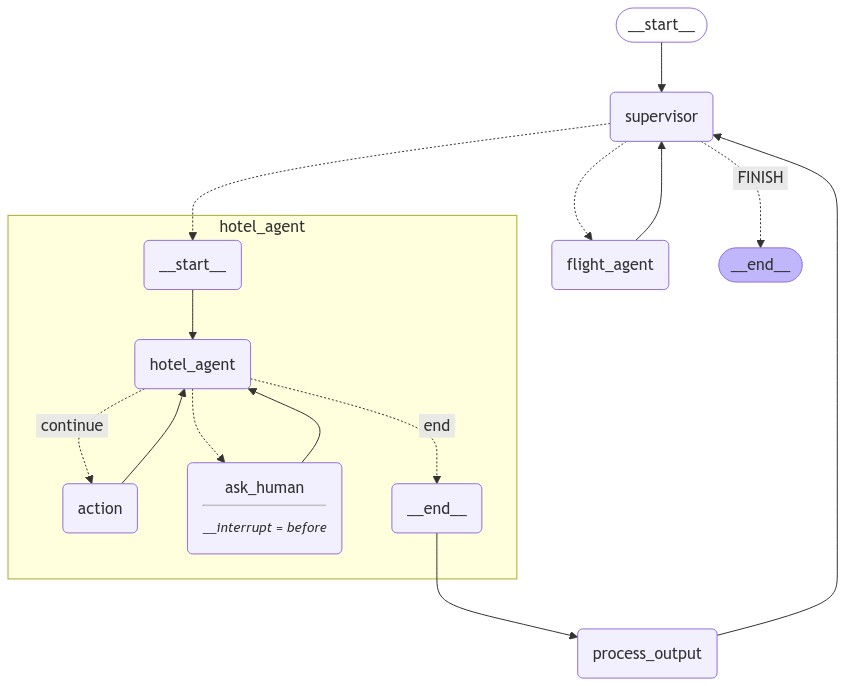

In [88]:
from IPython.display import Image, display

supervisor_agent_graph = full_workflow.compile(
    checkpointer=memory,
)

# display subgraph using xray=1
display(Image(supervisor_agent_graph.get_graph(xray=1).draw_mermaid_png()))

In [89]:
config = {"configurable": {"thread_id": "133"}}
input_message = HumanMessage(
    content="I want to book a hotel for 8th October for 3 nights"
)
for event in supervisor_agent_graph.stream(
    {"messages": [input_message]}, config, stream_mode="values", subgraphs=True
):
    event[1]["messages"][-1].pretty_print()

================================ Human Message =================================

I want to book a hotel for 8th October for 3 nights
next='hotel_agent'
Supervisor output: {'next': 'hotel_agent', 'messages': [HumanMessage(content='Supervisor decided: hotel_agent', additional_kwargs={}, response_metadata={}, name='supervisor')]}
================================ Human Message =================================
Name: supervisor

Supervisor decided: hotel_agent
================================ Human Message =================================
Name: supervisor

Supervisor decided: hotel_agent
================================== Ai Message ==================================

[{'type': 'text', 'text': 'Okay, let me help you find a hotel for your stay. To search for available hotels, I need to know the city you want to stay in. Please provide the city name.'}, {'type': 'tool_use', 'name': 'AskHuman', 'input': {'question': 'What city would you like to book a hotel in?'}, 'id': 'tooluse_W_Q8LrhxQp-F

In the above example execution is interrupted if agent needs to ask additional question. Then we can update state of subgraph and then continue execution

In [90]:

state = supervisor_agent_graph.get_state(config, subgraphs=True)
state.tasks[0]

PregelTask(id='a4f8e1f7-b5c1-245f-4197-e8ab6458bcf1', name='hotel_agent', path=('__pregel_pull', 'hotel_agent'), error=None, interrupts=(), state=StateSnapshot(values={'messages': [HumanMessage(content='I want to book a hotel for 8th October for 3 nights', additional_kwargs={}, response_metadata={}, id='9475bfe4-a51f-4f3e-a6fd-83172ce0b031'), HumanMessage(content='Supervisor decided: hotel_agent', additional_kwargs={}, response_metadata={}, name='supervisor', id='154f3289-f2f9-4011-8502-cb3590d31715'), AIMessage(content=[{'type': 'text', 'text': 'Okay, let me help you find a hotel for your stay. To search for available hotels, I need to know the city you want to stay in. Please provide the city name.'}, {'type': 'tool_use', 'name': 'AskHuman', 'input': {'question': 'What city would you like to book a hotel in?'}, 'id': 'tooluse_W_Q8LrhxQp-FevJ3d36VZA'}], additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': '85bd74f3-526c-4f3d-a8dc-d2a9387ecb37', 'HTTPStatusCode': 

`Ask_Human` is a dummy tool node, we need to find the `tool_id` from the subgraph and the update the state with tool message.

In [91]:
def extract_tool_id(pregel_task):
    # Navigate to the messages in the state
    messages = pregel_task.state.values.get("messages", [])

    # Find the last AIMessage
    for message in reversed(messages):
        if isinstance(message, AIMessage):
            # Check if the message has tool_calls
            tool_calls = getattr(message, "tool_calls", None)
            if tool_calls:
                # Return the id of the first tool call
                return tool_calls[0]["id"]

    # If no tool_id is found, return None
    return None


# Assuming 'output' is the PregelTask object you provided
tool_id = extract_tool_id(state.tasks[0])
print(tool_id)  # This should print: tooluse_qWu6nEewS5OSqxszIgdfNA

tooluse_W_Q8LrhxQp-FevJ3d36VZA


While updating the state of subgraph, we need to make sure to pass config of subgraph - `state.tasks[0].state.config`

In [92]:
user_input=input("User: ")

In [93]:
# We now create the tool call with the id and the response we want
tool_message = [{"tool_call_id": tool_id, "type": "tool", "content": user_input}]


supervisor_agent_graph.update_state(
    state.tasks[0].state.config, {"messages": tool_message}, as_node="ask_human"
)

supervisor_agent_graph.get_state(state.tasks[0].state.config).next

('ask_human',)

In [94]:
for event in supervisor_agent_graph.stream(
   None, config, stream_mode="values", subgraphs=True
):
    event[1]["messages"][-1].pretty_print()

================================ Human Message =================================
Name: supervisor

Supervisor decided: hotel_agent
================================= Tool Message =================================

Paris
================================== Ai Message ==================================

[{'type': 'text', 'text': 'Got it, you need a hotel in Paris for 3 nights, checking in on October 8th. Let me search for available hotels:'}, {'type': 'tool_use', 'name': 'suggest_hotels', 'input': {'city': 'Paris', 'checkin_date': '2023-10-08'}, 'id': 'tooluse_opm0n6A-RvWwprcZc-kX9g'}]
Tool Calls:
  suggest_hotels (tooluse_opm0n6A-RvWwprcZc-kX9g)
 Call ID: tooluse_opm0n6A-RvWwprcZc-kX9g
  Args:
    city: Paris
    checkin_date: 2023-10-08
================================= Tool Message =================================
Name: suggest_hotels

{"hotels": ["Hotel D", "Hotel E", "Hotel F"], "checkin_date": "2023-10-08", "checkout_date": "2023-10-17", "price": 168} FINISHED
======================

## Conclusion

In this notebook, we explored building a multi-agent system using LangGraph to handle travel-related tasks. Key takeaways include:

- Multi-agent systems can overcome limitations of single-agent setups, providing more flexibility and efficiency for complex tasks
- We created specialized agents for flight and hotel bookings, each with their own set of tools and capabilities
- A supervisor agent was implemented to orchestrate the workflow, deciding which specialized agent to call based on the user's input
- We demonstrated how to build agents both using pre-built components (like create_react_agent) and from scratch for more control. The use of LangGraph allowed us to create a flexible workflow, incorporating conditional logic and subgraphs
